<a href="https://colab.research.google.com/github/Yodai1996/CV/blob/master/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl https://colab.chainer.org/install | sh -
!apt-get install -y graphviz
!python -c 'import chainer; chainer.print_runtime_info()'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  25483      0 --:--:-- --:--:-- --:--:-- 25483
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 

In [0]:
!pip install chainercv matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import glob
import cupy
import chainercv
import matplotlib
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import iterators, optimizers, training, datasets
from chainer.datasets import split_dataset_random
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu
from chainer.training import extensions
import numpy as np

import os
import xml.etree.ElementTree as ET
from chainercv.datasets import VOCBboxDataset
from chainercv.visualizations import vis_bbox
from chainercv.links import SSD300
from chainercv.links.model.ssd import multibox_loss

from IPython.display import Image
from PIL import Image
from chainer import reporter
from chainer import cuda
from chainercv import evaluations

In [0]:
!if [ ! -d train ]; then curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/train.zip && unzip train.zip && rm -rf train.zip; fi
!if [ ! -d val ]; then curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/val.zip && unzip val.zip && rm -rf val.zip; fi

In [0]:
def create_dataset(img_files, tgt_files):
  img = datasets.ImageDataset(img_files)
  img = datasets.TransformDataset(img, lambda x: x/255.)
  tgt = datasets.ImageDataset(tgt_files, dtype = np.float32)  #dtype = np.float32
  dataset = datasets.TupleDataset(img, tgt)
  return dataset  


def create_datasets():
  train_img_files   = sorted(glob.glob("train/image/*.png"))
  train_label_files = sorted(glob.glob("train/label/*.png"))  
  val_img_filenames = sorted(glob.glob('val/image/*.png'))
  val_label_filenames = sorted(glob.glob('val/label/*.png'))

  train = create_dataset(train_img_files, train_img_files)
  val   = create_dataset(val_img_filenames, val_img_filenames)

  return train, val  

In [0]:
train, val = create_datasets()
val_size = len(val)

FIXME_1 = 32
FIXME_2 = 64

FIXME_3 = 64
FIXME_4 = 128
FIXME_5 = 128

In [0]:
class FCN(chainer.Chain):
    def __init__(self, out_h, out_w, n_class=1):
        super().__init__()
        with self.init_scope():
            # L.Convolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Convolution2D(out_ch, ksize, stride, pad)
            # とかくこともできます．
            self.conv1 = L.Convolution2D(None, FIXME_1, ksize=5, stride=2, pad=2)  #shape will be half 
            self.conv2 = L.Convolution2D(None, FIXME_2, ksize=5, stride=2, pad=2)  #shape will be half
            self.conv3 = L.Convolution2D(None, FIXME_3, ksize=3, stride=1, pad=1)  #not change shape 
            self.conv4 = L.Convolution2D(None, FIXME_4, ksize=3, stride=1, pad=1)  #not change shape 
            self.conv5 = L.Convolution2D(None, FIXME_5, ksize=1, stride=1, pad=0)  #not change shape 
            # L.Deconvolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Deconvolution2D(out_ch, ksize, stride, pad)
            # と書くこともできます．
            self.deconv6 = L.Deconvolution2D(None, n_class, ksize=32, stride=16, pad=8)
        self.out_h = out_h
        self.out_w = out_w

    def forward(self, x):
        h = F.relu(self.conv1(x))
        print(h.shape)
        h = F.max_pooling_2d(h, 2, 2)
        print(h.shape)

        h = F.relu(self.conv2(h))
        print(h.shape)
        h = F.max_pooling_2d(h, 2, 2)
        print(h.shape)

        h = F.relu(self.conv3(h))
        print(h.shape)
        h = F.relu(self.conv4(h))
        print(h.shape)
        h = self.conv5(h)
        print(h.shape)
        h = self.deconv6(h)
        print(h.shape)

        return h.reshape(x.shape[0], 1, h.shape[2], h.shape[3])
      
   
  
class FCN_Unet(chainer.Chain):
    def __init__(self, out_h, out_w, n_class=1, residual=False, u_net=True):
        super().__init__()
        with self.init_scope():
            # L.Convolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Convolution2D(out_ch, ksize, stride, pad)
            # とかくこともできます．
            self.conv1 = L.Convolution2D(None, FIXME_1, ksize=5, stride=2, pad=2)  #shape will be half 
            self.conv2 = L.Convolution2D(None, FIXME_2, ksize=5, stride=2, pad=2)  #shape will be half
            self.conv3 = L.Convolution2D(None, FIXME_3, ksize=3, stride=1, pad=1)  #not change shape 
            self.conv4 = L.Convolution2D(None, FIXME_4, ksize=3, stride=1, pad=1)  #not change shape 
            self.conv5 = L.Convolution2D(None, FIXME_5, ksize=1, stride=1, pad=0)  #not change shape
            
            self.conv6 = L.Convolution2D(None, FIXME_1, ksize=5, stride=1, pad=2)  #not change shape
            
            # L.Deconvolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Deconvolution2D(out_ch, ksize, stride, pad)
            # と書くこともできます．
            self.deconv6 = L.Deconvolution2D(None, FIXME_1, ksize=16, stride=8, pad=4)
            self.deconv7 = L.Deconvolution2D(None, n_class, ksize=2 , stride=2, pad=0)
            
        self.out_h = out_h
        self.out_w = out_w
        self.residual = residual
        self.u_net = u_net

    def forward(self, x):
        h1 = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h1, 2, 2)
        
        #print(h.shape)

        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)

        #print(h.shape)
        
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        
        #以下はなくてもかわらん
        #h = self.conv5(h)

        #print(h.shape)        
        
        h = self.deconv6(h)
        
        if self.u_net:
          #residual or concat
          if self.residual:
            h = h + h1
          else:
            h = F.concat((h,h1), axis=1)

        #print(h.shape)        
        
        h = F.relu(self.conv6(h))
        h = self.deconv7(h)      
        
        #AEの想定
        h = F.sigmoid(h)*256

        #print(h.shape)
        
        return h.reshape(x.shape[0], 1, h.shape[2], h.shape[3])

In [0]:
class PixelwiseClassifier(chainer.Chain):

    def __init__(self, predictor):
        super().__init__()
        with self.init_scope():
            # 学習対象のモデルをpredictorとして保持しておく
            self.predictor = predictor

    def __call__(self, x, t):
        # 学習対象のモデルでまず推論を行う
        y = self.predictor(x)

        loss = F.mean_squared_error(y, t)
        reporter.report({'loss': loss}, self)  #とりあえずlossだけ見れればいい

        return loss

In [0]:
def my_trainer(batchsize, train, val, stop, device=-1, u_net=False, log_trigger=(1, 'epoch')):
    model = FCN_Unet(out_h=256, out_w=256, u_net=u_net)
    train_model = PixelwiseClassifier(model)

    optimizer = optimizers.Adam(eps=1e-05)
    optimizer.setup(train_model)

    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)

    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    trainer = training.trainer.Trainer(updater, stop, out='result_fcn')

    logging_attributes = [
        'epoch', 'main/loss', 'val/main/loss']
    trainer.extend(extensions.LogReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PrintReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.Evaluator(val_iter, train_model, device=device), name='val')
    trainer.extend(extensions.dump_graph('main/loss'))
    return trainer
  
  
def show_predicts(trainer, val, device=-1, n_sample=val_size):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor

    for i in range(n_sample):
        img, label = val[i]
        img = cuda.to_gpu(img, device)
        pred = model(img[np.newaxis])
        pred = cuda.to_cpu(pred.data[0][0])
        #print(pred.dtype)
        fig, axes = plt.subplots(1, 2)

        axes[0].set_axis_off()
        axes[0].imshow(pred, cmap='gray')

        axes[1].set_axis_off()
        tgt = label[0]
        axes[1].imshow(tgt, cmap='gray')

        plt.show()

In [0]:
%%time
trainer = my_trainer(32, train, val, (200, 'epoch'), device=0, u_net=False, log_trigger=(10, 'epoch'))
trainer.run()

epoch       main/loss   val/main/loss
10          1157.33     1311.62        
20          1010.64     1058.85        
30          778.223     874.048        
40          794.052     803.955        
50          772.383     752.08         
60          630.696     716.982        
70          663.98      684.832        
80          675.701     684.075        
90          652.068     743.038        
100         543.227     628.677        
110         590.015     638.824        
120         524.927     602.467        
130         569.543     592.5          
140         518.471     579.521        
150         494.965     605.965        
160         450.609     562.619        
170         463.427     553.862        
180         396.525     549.098        
190         421.183     547.784        
200         403.787     538.681        
CPU times: user 1min 39s, sys: 29.4 s, total: 2min 8s
Wall time: 2min 34s


Loss


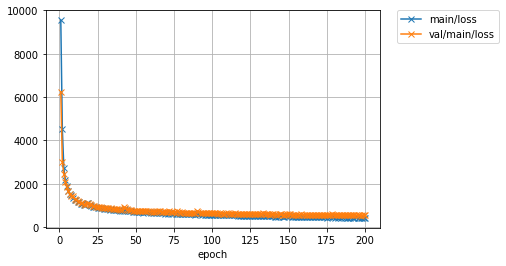

In [0]:
from IPython.display import Image

print('Loss')
Image('result_fcn/loss.png')

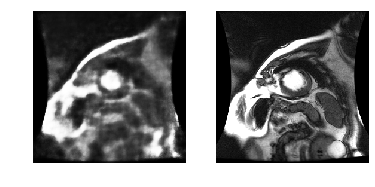

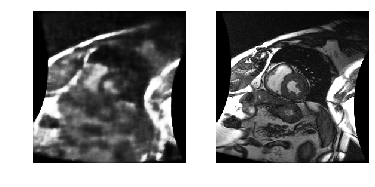

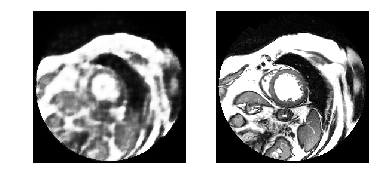

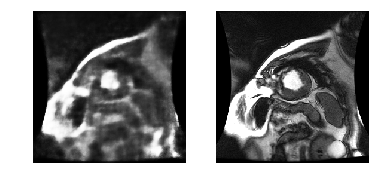

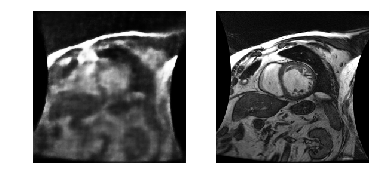

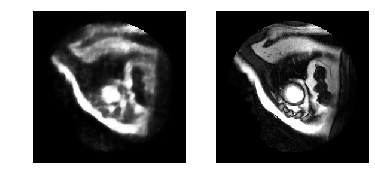

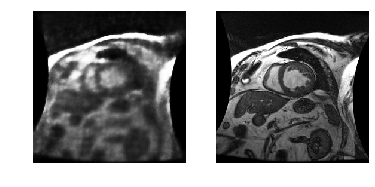

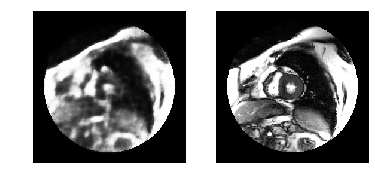

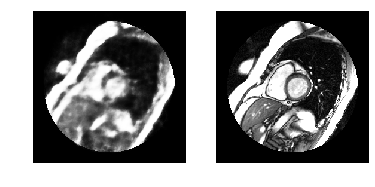

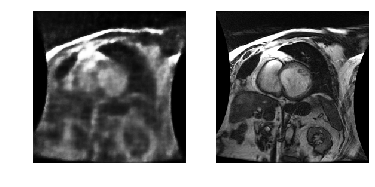

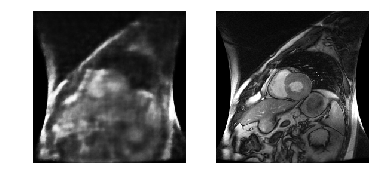

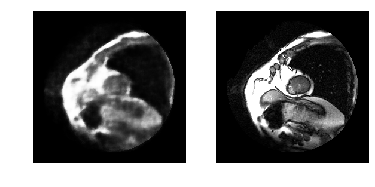

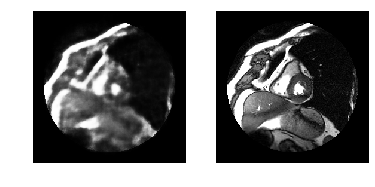

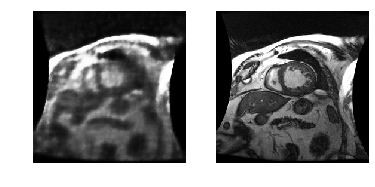

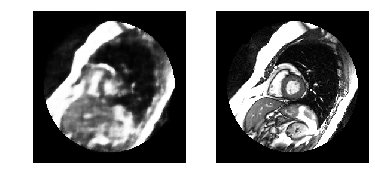

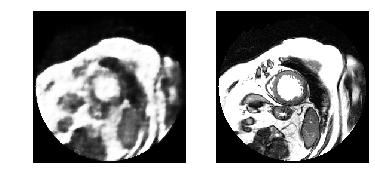

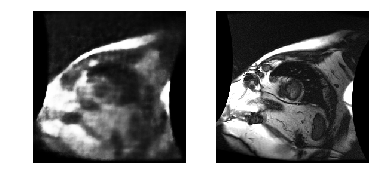

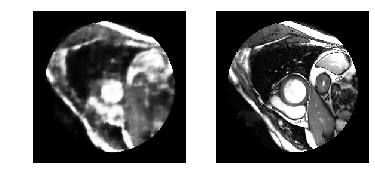

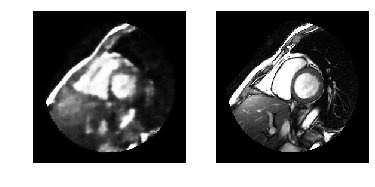

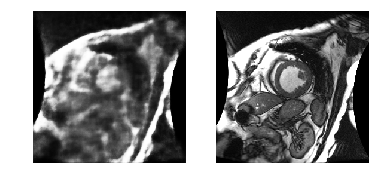

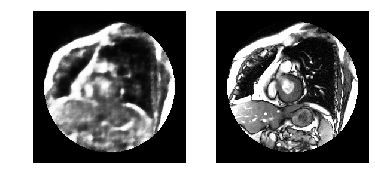

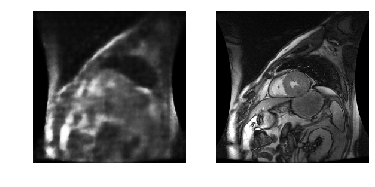

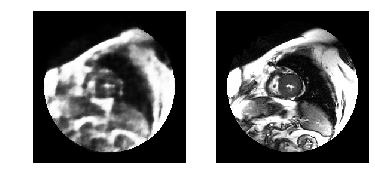

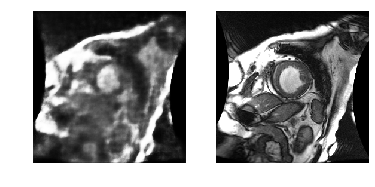

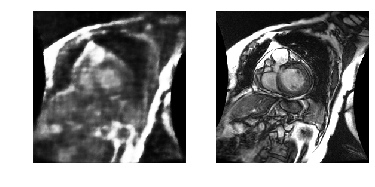

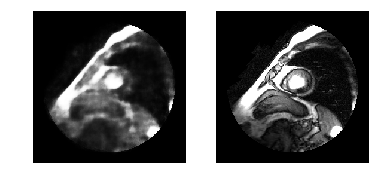

In [0]:
show_predicts(trainer, val, device=0, )

In [0]:
%%time
trainer = my_trainer(32, train, val, (100, 'epoch'), device=0, u_net=True, log_trigger=(10, 'epoch'))
trainer.run()

epoch       main/loss   val/main/loss
10          230.851     210.33         
20          107.817     107.822        
30          88.6696     83.2421        
40          74.8768     71.3307        
50          66.9749     64.4984        
60          55.5577     58.3117        
70          54.073      53.9024        
80          55.3406     52.5376        
90          54.9498     48.2873        
100         43.2807     46.5796        
CPU times: user 59.3 s, sys: 22.8 s, total: 1min 22s
Wall time: 1min 34s


Loss


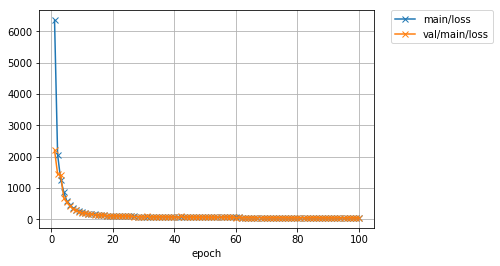

In [0]:
from IPython.display import Image

print('Loss')
Image('result_fcn/loss.png')

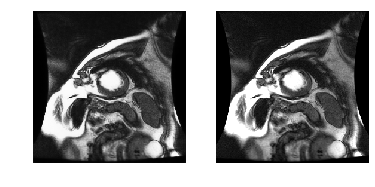

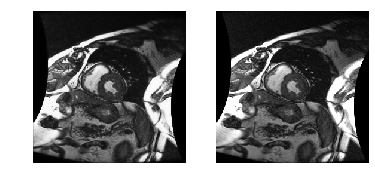

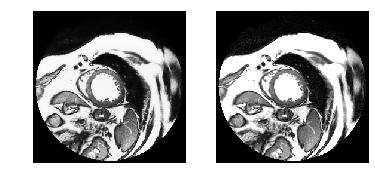

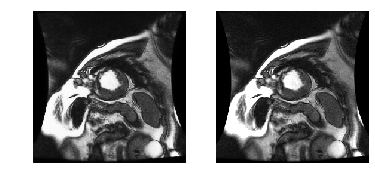

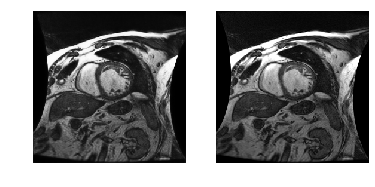

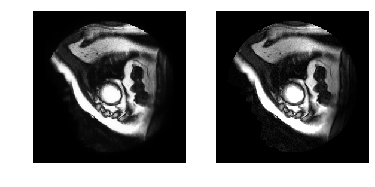

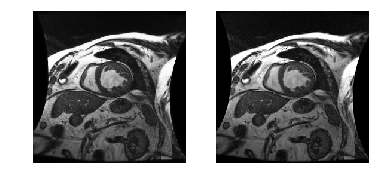

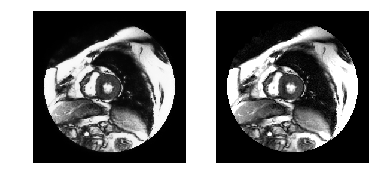

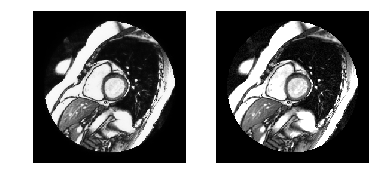

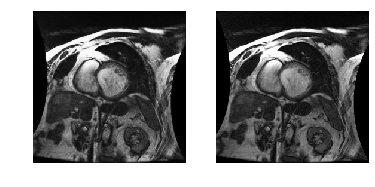

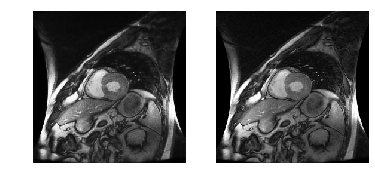

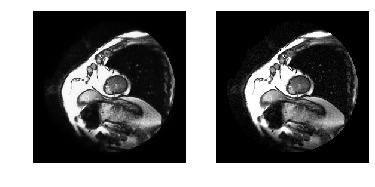

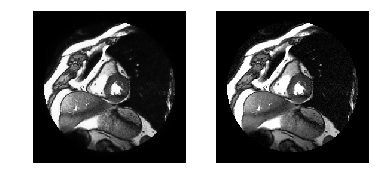

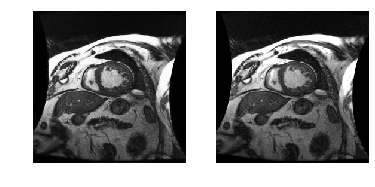

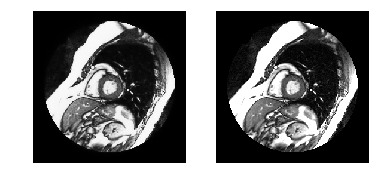

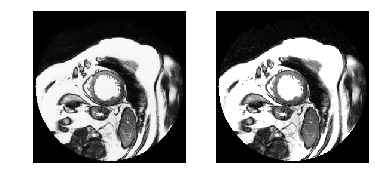

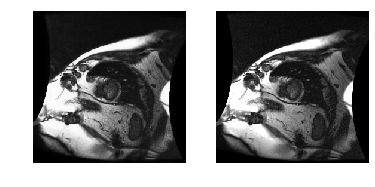

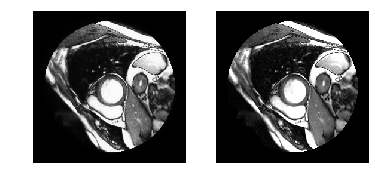

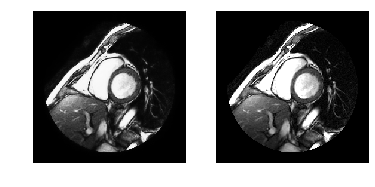

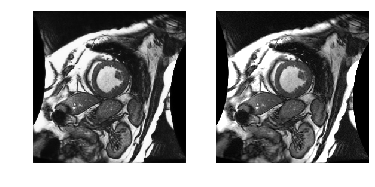

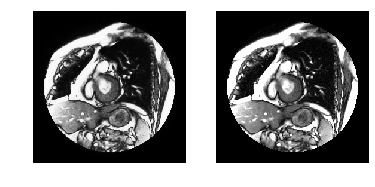

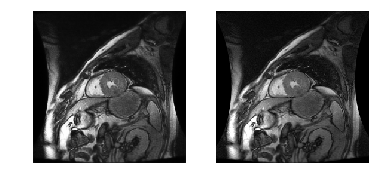

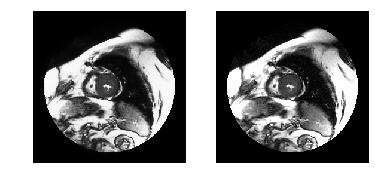

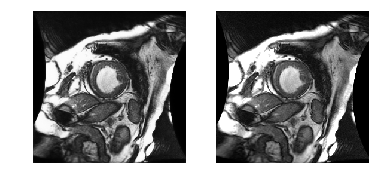

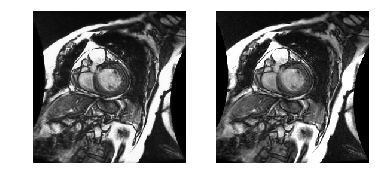

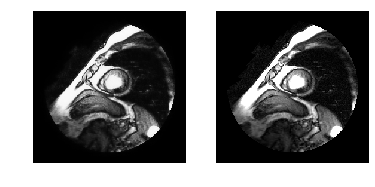

In [0]:
show_predicts(trainer, val, device=0, )

## 考察
skip-connectionの有無で、ぼやけるかぼやけないかが顕著。

今回はただのAutoEncoderに留まったが、同じアーキテクチャを、
Image to Image というタスク(例えば、モノクロ画像からカラー付き画像を得る、など)に応用できる。

また、損失関数をどうするかは結構難しい話（単純なsigmoid_cross_entropyだと今回のようにぼやけがち）ゆえ、

それ自体も機械に学習させるということでGANも考えられる（今回のアーキテクチャはGeneratorとして使う、conditional GANなど）。